Pyresample
-----------


[Pyresample repository](http://github.com/pytroll/pyresample)

[Docs](http://pyresample.readthedocs.org/en/latest/)

This demo shows basic usage of pyresample:
 * how to resample data with latitudes and longitudes to a grid
 * how to make a quick data plot on geographical grid
 * how to limit data to the target geographic area
 * how to resample multiple datasets that share the coordinates faster by calculating resampling distance once

This notebook is hosted at: https://github.com/foss-sat/pytroll-demo
 

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [9]:
from pyresample import geometry, kd_tree, plot
import os, gzip
import netCDF4

In [3]:
# Get netcdf data
os.system("wget ftp://osisaf.met.no/reprocessed/ice/conc/v1p1/2008/07/ice_conc_nh_ease-125_reproc_200807011200.nc.gz -O sic.nc.gz && gunzip sic.nc.gz")

512

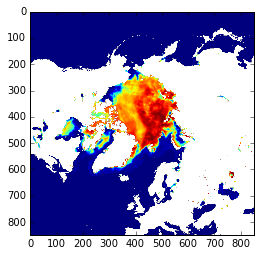

In [32]:
# Load data and create Swath area
dataset = netCDF4.Dataset('sic.nc')
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]
ice_conc = dataset.variables['ice_conc'][:]
dummy_ice_conc = ice_conc * -1.

imshow(ice_conc[0,:,:])

swath_def = geometry.SwathDefinition(lons=lons, lats=lats)

In [5]:
# Define target area
area_def = geometry.AreaDefinition(
    area_id = 'Istjenesten polar stereographic',
    name = 'istjenesten_stere_north_3k',
    proj_id = 'stere',
    proj_dict = {'a' : '6371228.0',
                 'units' : 'm',
                 'lon_0' : '0',
                 'proj'  : 'stere',
                 'lat_0' : '90',
                 'lat_ts': '90'},
    x_size = 2432,
    y_size = 3584,
    area_extent =(-3850000.0, -5350000.0, 3750000.0, 5850000.0)
    )


In [51]:
# Resample swath to grid using custom number of cores
%timeit result = kd_tree.resample_nearest(swath_def, ice_conc, area_def, radius_of_influence=20000, nprocs=8)
# imshow(result)

1 loops, best of 3: 2.32 s per loop


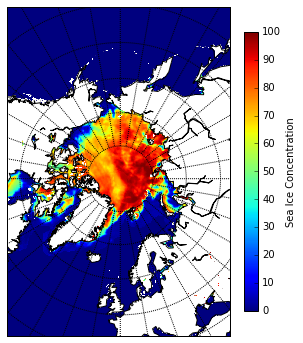

In [27]:
# quick plotting
# Make output image resolution higher than default one
from matplotlib.pyplot import figure; fig = figure(figsize=(5,10))
plot.show_quicklook(area_def, result, num_meridians=10, num_parallels=10, label='Sea Ice Concentration')

In [52]:
# Precompute index arrays
valid_input_index, valid_output_index, index_array, distance_array = kd_tree.get_neighbour_info(swath_def,
                                                       area_def, 50000, neighbours=1)

print "Number of valid pixels %i" % valid_input_index.sum()
# Resample
%timeit result = kd_tree.get_sample_from_neighbour_info('nn', area_def.shape, dummy_ice_conc, valid_input_index, valid_output_index, index_array)

Number of valid pixels 667193
1 loops, best of 3: 346 ms per loop


Number of valid pixels
10 loops, best of 3: 37.7 ms per loop


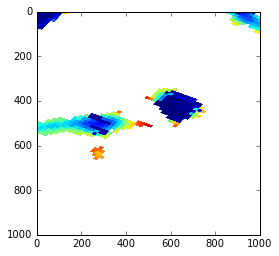

In [67]:
# Reduce data to relevant geographic area
# Use smaller target area
small_area_def = geometry.AreaDefinition(
            'Gulf of Finland area',
            'Test area',
            'stere_north',
            {'proj': 'laea', 'lat_0':'60', 'lon_0':'30', 'a':'6371228.0', 'units':'m'},
            1000,
            1000,
            (-319929.9787432588, -544766.0133604591, 319929.9787432582, 566082.4534703239)) 

# Get indices
valid_input_index, valid_output_index, index_array, distance_array = kd_tree.get_neighbour_info(swath_def,
                                                       small_area_def, 50000, neighbours=1)
# Get pixel indices that belong to the target area
from pyresample import data_reduce
grid_lons, grid_lats = small_area_def.get_lonlats()
valid_index = data_reduce.get_valid_index_from_lonlat_grid(grid_lons,
                                                           grid_lats,
                                                           lons,
                                                           lats,
                                                           radius_of_influence=10000)

print "Number of valid pixels" % valid_input_index.sum()
%timeit result = kd_tree.get_sample_from_neighbour_info('nn', small_area_def.shape, ice_conc, valid_input_index, valid_output_index, index_array)
imshow(result)

For more resampling options (gaussian, custom weigting) and resampling uncertainty see docs